In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from math import pi
from scipy.stats import unitary_group
from matplotlib.ticker import MaxNLocator
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd

In [2]:
def create_CB_circ(nqubits, theta):
        
    """
    Creates a parametrized CB circuit
    
    Args:  
        nqubits: int
                 number of qubits
        theta: numpy array
               unitary parameters
                     
    Returns:
        qc: qiskit circuit
    """
    
    p = len(theta) // (4 * (nqubits // 2) * 2)          # numbers of layers
    qc = QuantumCircuit(nqubits)
    
    for i in range(p):
        alpha = theta[0::4]
        beta = theta[1::4]
        gamma = theta[2::4]
        zeta = theta[3::4]
      
    
    if nqubits % 2 == 0:
        
        pairs = []                #set of pairs

        for i in range(nqubits):
            if i % 2 == 0:
                pairs.append((i, (i + 1) % nqubits))
        for i in range(nqubits):
            if i % 2 == 1:
                pairs.append((i, (i + 1) % nqubits))


        for irep in range(p * nqubits):    # one irep creats one block
            if irep % nqubits == 0:
                qc.barrier()
            i, j = pairs[irep % nqubits]
            qc.rx(alpha[irep], i)
            qc.rx(beta[irep], j)
            qc.cx(i, j)
            qc.rz(gamma[irep], i)
            qc.rz(zeta[irep], j)

                
    if nqubits % 2 == 1:
        
        pairs = []                #set of pairs

        for i in range(nqubits):
            if (i % 2 == 0) and (i != nqubits - 1):
                pairs.append((i, (i + 1) % nqubits))
        for i in range(nqubits):
            if i % 2 == 1:
                pairs.append((i, (i + 1) % nqubits))


        for irep in range(p * (nqubits - 1)):    # one irep creats one block
            if irep % (nqubits - 1) == 0:
                qc.barrier()
            i, j = pairs[irep % (nqubits - 1)]
            qc.rx(alpha[irep], i)
            qc.rx(beta[irep], j)
            qc.cx(i, j)
            qc.rz(gamma[irep], i)
            qc.rz(zeta[irep], j)        

    return qc



In [3]:
def outputstate(theta, nqubits):
    """
    Prepare state
    
    Args: 
        theta: numpy array
                array of parameters
        nqubits: int
                number of qubits
            
    Returns:
        state: numpy array
                prepared state
    
    """
    
    backend = Aer.get_backend('statevector_simulator')
    qc = create_CB_circ(nqubits, theta)
    
    job = backend.run(qc)
    result = job.result()
    state = result.get_statevector(qc).data

    return state


In [4]:
def energy(theta, H, nqubits):
    
    """
    Compute enery
    
    Args:
        theta: numpy array
                array of parameters
        H: numpy array
            Telescope hamiltonian
        nqubits: int
            number of qubits
            
     Returns:
         E: int
             energy
    """
    
    state = outputstate(theta, nqubits)
    
    return np.real(np.dot(state.conj(), np.dot(H, state)) )


In [5]:
def ising_1D_1R(nqubits, J_array, h_array):
    
    """
    Obtain transvers field ising hamiltonian 
    
    Args: 
        nqubits: int
                number of particles
        h: int
                transverse field strength 
                
     Returns:
         H: numpy array
                hamiltonian
    """

    edges = np.zeros((nqubits - 1, 2)) 

    for i in range(nqubits - 1):
        edges[i][0] = i + 1
        edges[i][1] = i + 2
      
            
    H = np.zeros((2**nqubits, 2**nqubits))
    Z = np.array([[1, 0], 
                  [0, -1]])
    I = np.array([[1, 0], 
                  [0, 1]])  
    X = np.array([[0, 1],
                  [1, 0]])
    
    for n in range(len(edges)):
        for edge in edges:  # run edges
            tmp = 1

            for i in range(1, nqubits + 1):
                if i == edge[0] or i == edge[1]:
                    tmp = np.kron(tmp, Z) 
                else:
                    tmp = np.kron(tmp, I) 

            H += tmp * J_array[n]

            
    for i in range(nqubits):
        tmp_X = 1
        for j in range(nqubits):
            if j == i:
                tmp_X = np.kron(tmp_X, X) 
            else:
                tmp_X = np.kron(tmp_X, I) 
        
        H += tmp_X * h_array[i]
        
    return H


In [6]:
def theta_for_ground_state(nqubits, p, H, cons):
    
    E_min = 1000
    for _ in range(1):
        
        init = np.random.uniform(0, 2 * pi, size=4 * p * (nqubits // 2) * 2)    #initial guess of parameters
        res = minimize(energy, init, args=(H, nqubits), method='SLSQP', constraints=cons, options={'gtol': 1e-06, 'maxiter': 100})
        
        if res.fun < E_min:
            E_min = res.fun
            theta = res.x
        
    return np.real(theta)


In [7]:
nqubits = 4               #number of qubits
p_max = 1                      #number of layers
t_max = 20
t_min = 5

In [8]:
# create hamiltonians and obtain optimal parameters


J_array = np.random.uniform(0.8, 1.2, size=(nqubits - 1))
h_array = np.random.uniform(5, 7, size=nqubits) * 1e-5

H = ising_1D_1R(nqubits, J_array, h_array)
with open('/home/dima/notebook/Noise/Execution time/H.csv', 'wb') as f:
    np.save(f, H) 
        
    

In [9]:
for p in np.linspace(1, p_max, p_max, dtype=int):

    E_array = np.array([])

    for t in np.linspace(t_min, t_max, t_max - t_min + 1, dtype=int):

        E_min = 1000
        
        def constraint(theta):
            return -np.sum(np.abs(theta)) + t
        
        cons = {'type':'ineq', 'fun': constraint}

        for _ in range (50):

            init = np.random.uniform(0, 2 * pi, size=(4 * p * (nqubits // 2) * 2))    #initial guess of parameters
            res = minimize(energy, init, args=(H, nqubits), method='SLSQP', constraints=cons, options={'gtol': 1e-06, 'maxiter': 1000})

            if res.fun < E_min:

                E_min = res.fun

        E_array = np.append(E_array, E_min)

        with open('/home/dima/notebook/Noise/Execution time/E_'+str(p)+'p.csv', 'wb') as f:
            np.save(f, E_array) 
            
    
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


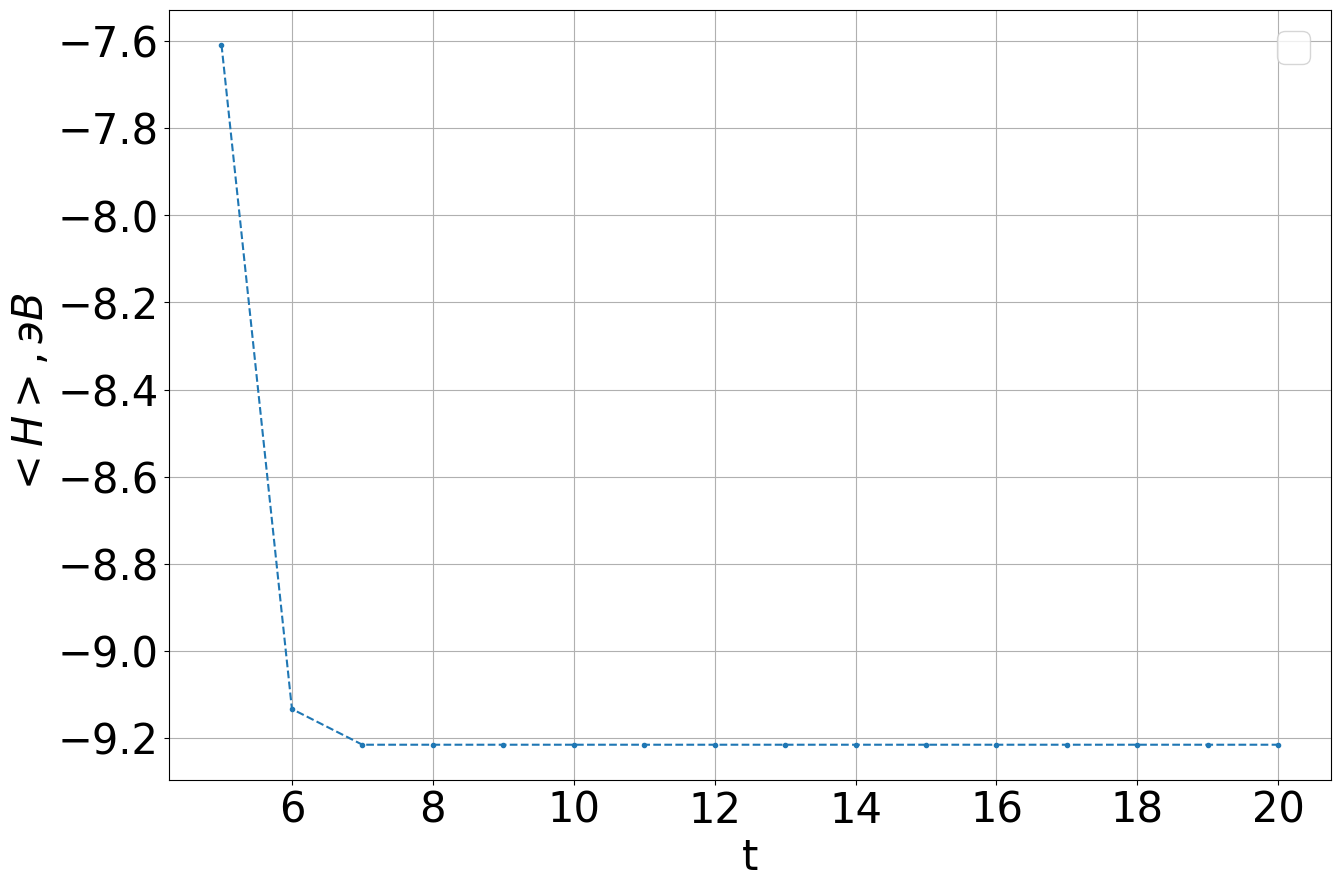

In [12]:
f,ax1 = plt.subplots(1,figsize = (15,10))


E_array = np.array([])
for p in np.linspace(1, p_max, p_max, dtype=int):
    
    with open('/home/dima/notebook/Noise/Execution time/E_'+str(p)+'p.csv', 'rb') as f:
        E = np.load(f) 
    N = nqubits


    ax1.plot(np.linspace(t_min, t_max, t_max - t_min + 1, dtype=int), E, '.--')
    
ax1.grid(alpha = 1)

ax1.set_xlabel('t', fontsize = 30 )
ax1.set_ylabel('$<H>, эВ$', fontsize = 30 )

ax1.legend(fontsize = 30)

ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)

plt.savefig('Execution time.pdf')
